In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import special
import mpmath as mp
#%matplotlib inline

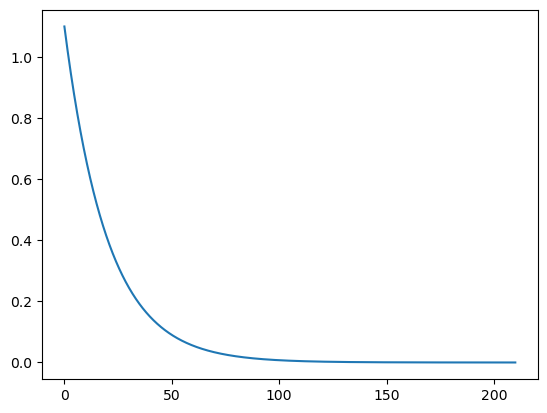

In [2]:
def l_OD_test(h, phi):
    z = np.exp(-h/20)*(1 + 0.1*np.cos(phi)**2)*np.heaviside(h, 0) + (1 - np.heaviside(h, 0))*(1 + 0.1*np.cos(phi)**2)
    z = z #- 2*np.exp(-0.5*((x - x_0*np.ones_like(x))**2 + (y - y_0*np.ones_like(y))**2)/sigma**2)/(2*np.pi*sigma**2)
    return z

h_data = np.arange(0, 210, 0.1)
phi_data = np.arange(0, 2*np.pi, 0.01)
l_OD_data = l_OD_test(h_data[:, None], phi_data[None, :])
l_OD = scipy.interpolate.RectBivariateSpline(h_data, phi_data, l_OD_data, kx=5, ky=5)
plt.plot(h_data, l_OD.ev(h_data, 0))


In [3]:
def inv_M(h, phi, args):
    R, D,  = args
    r = h + R
    M_hh = 1/D + l_OD.partial_derivative(2, 0)(h, phi)
    M_pp = 1/D + l_OD.partial_derivative(1, 0)(h, phi)/r[:, None] + l_OD.partial_derivative(0, 2)(h, phi)/r[:, None]**2
    M_hp = l_OD.partial_derivative(0, 1)(h, phi)/r[:, None]**2 - l_OD.partial_derivative(1, 1)(h, phi)/r[:, None]

    res = np.array([[M_hh, M_hp], [M_hp, M_pp]])
    res = np.transpose(res, (2, 3, 0, 1))
    return res

def magnification_det(h, phi, args):
    A = np.zeros([2, 2, np.size(h), np.size(phi)])
    det_inv_M = np.zeros([np.size(h), np.size(phi)])
    A = inv_M(h, phi, args)
    det_inv_M = np.linalg.det(A)
    return (det_inv_M)

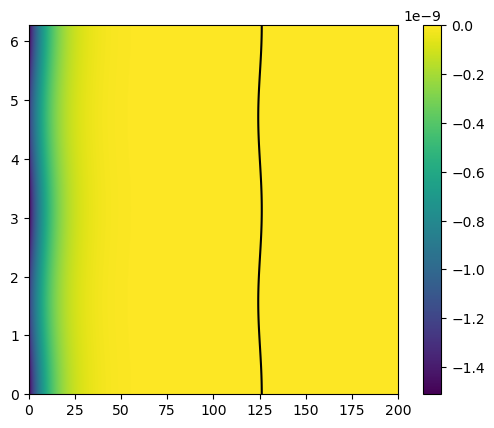

In [4]:
args = 1e+5, 1e+9
h = np.linspace(0, 200, 5000)
phi = np.linspace(0, 2*np.pi, 500)
det_inv_M = np.transpose(magnification_det(h, phi, args))
plt.imshow(det_inv_M, origin = 'lower',extent=[h.min(), h.max(), phi.min(), phi.max()], aspect=(h.max() - h.min()) / (phi.max() - phi.min()))
plt.colorbar()
X_cr = plt.contour(h, phi, det_inv_M, levels = [0], colors = 'k')

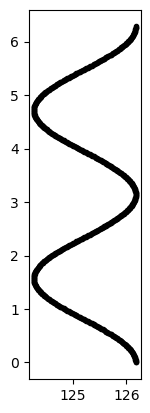

In [5]:
h_cr, phi_cr = [], []
i = 0
for path in X_cr.get_paths():
    v = path.vertices
    h_cr.append(v[:, 0])  
    phi_cr.append(v[:, 1])  
    #display(v)
    i = i + 1

x_c = np.array(h_cr, dtype=object)
y_c = np.array(phi_cr, dtype=object)
plt.plot(h_cr, phi_cr, color = 'k', marker= '.')
plt.gca().set_aspect('equal')
plt.show()

In [6]:
def find_caustics_scalar(h_cr, phi_cr, args):
    R, D = args
    r_cr = h_cr + R
    # Evaluate derivatives with grid=False to treat inputs as points
    dtau_dh = np.array([l_OD.partial_derivative(1, 0)(h, p, grid=False) for h, p in zip(h_cr, phi_cr)])
    dtau_dphi = np.array([l_OD.partial_derivative(0, 1)(h, p, grid=False) for h, p in zip(h_cr, phi_cr)])
    # Calculate caustic coordinates
    s_x = r_cr*np.cos(phi_cr)/D +  np.cos(phi_cr)*dtau_dh - np.sin(phi_cr)*dtau_dphi/r_cr
    s_y = r_cr*np.sin(phi_cr)/D +  np.sin(phi_cr)*dtau_dh + np.cos(phi_cr)*dtau_dphi/r_cr
    return s_x, s_y
find_caustics = np.vectorize(find_caustics_scalar)

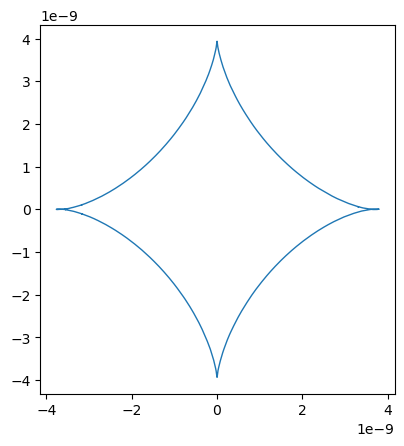

In [7]:
for h_ in h_cr:
    for phi_ in phi_cr:
        s_x, s_y = find_caustics_scalar(h_, phi_, args)
#The result is a bit noisy. Let's filter it wit a Savitzky-Golay filter to remove the fast oscillations
window = 10
pol_n = 1
s_x = scipy.signal.savgol_filter(s_x, window, pol_n)
s_y = scipy.signal.savgol_filter(s_y, window, pol_n)
plt.plot(s_x, s_y, linewidth = 1)
plt.gca().set_aspect(1)

In [8]:
def source_given_lens(l, args):
    R, D = args
    l_x, l_y = l
    h = -R + D*np.sqrt(l_x**2 + l_y**2)
    r = h + R
    phi = np.arctan2(l_y, l_x)
    l_h = l_OD.partial_derivative(1, 0)(h, phi, grid=False)
    l_phi = l_OD.partial_derivative(0, 1)(h, phi, grid=False)
    s_x = (1. + (D/r)*l_h)*l_x - l_y*(l_phi/D)*(D/r)**2
    s_y = (1. + (D/r)*l_h)*l_y + l_x*(l_phi/D)*(D/r)**2
    return s_x, s_y

(0.6363961030678928, 0.35355339059327373)

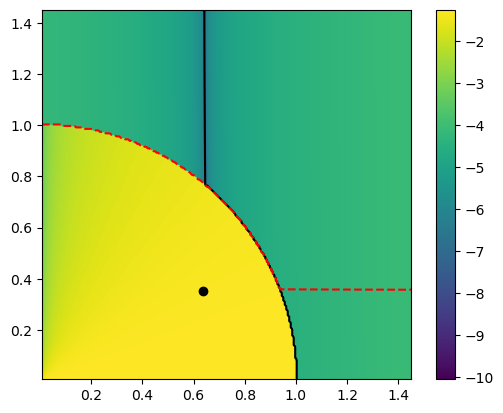

In [125]:
R, D = args
#s_x_true, s_y_true = -0.01, -0.06
#l = 0.5*1e-6*s_x_true*(np.arange(-1, 1, 0.01))
s_x_true, s_y_true = 0.9*(R/D)/np.sqrt(2), 0.5*(R/D)/np.sqrt(2)
#s_x_true, s_y_true = 0.9*(R/D)/np.sqrt(2), 0.9*(R/D)/np.sqrt(2)
l = np.sqrt(s_y_true**2 + s_x_true**2)*(np.arange(0.01, 2, 0.008))
l_array = l[None, :], l[:, None]
s = source_given_lens(l_array, args)
s_x, s_y = s

y = s_x - s_x_true
y = np.log10(np.fabs(y))
R_ang = R/D
plt.imshow(y, extent=[l[0]/R_ang, l[-1]/R_ang, l[0]/R_ang, l[-1]/R_ang], origin='lower',
           vmin=np.min(y), vmax=np.max(y))
plt.colorbar()
s_x_contour = plt.contour(l/R_ang, l/R_ang, s_x - s_x_true , levels = [0.], colors = 'k')
s_y_contour = plt.contour(l/R_ang, l/R_ang, s_y - s_y_true, levels = [0], colors = 'r', linestyles = 'dashed')
plt.scatter(s_x_true/R_ang, s_y_true/R_ang, color = 'k')
plt.gca().set_aspect(1)
s_x_true/R_ang, s_y_true/R_ang

In [140]:
lens_x = []
i = 0
for path in s_x_contour.get_paths():
    if i%100 == 0:
        v = path.vertices
        lens_x.append(v)   
    i = i + 1
lens_x = np.asarray(lens_x)[0, :, :]

lens_y = []
i = 0
for path in s_y_contour.get_paths():
    if i%100 == 0:
        v = path.vertices
        lens_y.append(v)  
    i = i + 1

lens_y = np.asarray(lens_y)[0, :, :]
lens_y.shape


def image(x, x_0, sigma):
    N = np.size(x_0[:, 0])
    I = np.zeros([np.size(x), np.size(x)])
    for i in range(0, N):
        r2 = (x[:, None] - x_0[i, 0])**2 + (x[None, :] - x_0[i, 1])**2
        mask = r2 < 5 * sigma**2
        I[mask] += np.exp(-0.5 * r2[mask] / sigma**2) / N
    return I
I_x = image(l/R_ang, lens_x, 0.01)
I_y = image(l/R_ang, lens_y, 0.01)

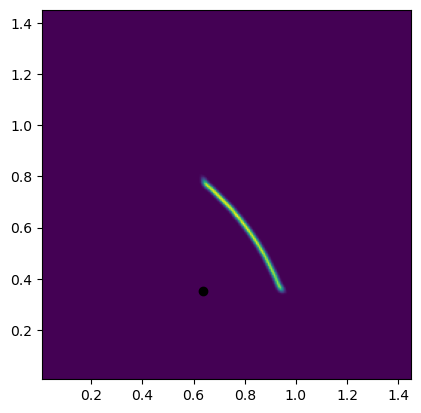

In [143]:

#
plt.plot(s_x_true/R_ang, s_y_true/R_ang, 'o', color = 'k')
plt.imshow(I_x.transpose()*I_y.transpose(), extent=[l[0]/R_ang, l[-1]/R_ang, l[0]/R_ang, l[-1]/R_ang], origin='lower',vmin=np.min(I_x*I_y), vmax=np.max(I_x*I_y))
#plt.imshow(I_y.transpose(), alpha = 0.5, extent=[l[0]/R_ang, l[-1]/R_ang, l[0]/R_ang, l[-1]/R_ang], origin='lower',vmin=np.min(I_y), vmax=np.max(I_y))
#plt.imshow(I_x.transpose(), alpha = 0.5, extent=[l[0]/R_ang, l[-1]/R_ang, l[0]/R_ang, l[-1]/R_ang], origin='lower', vmin=np.min(I_x), vmax=np.max(I_x))

